# **Loading data and packages**

**Libraries import**

In [5]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from joblib import load, dump

from sklearn.model_selection import (
    train_test_split, LeaveOneOut, cross_validate, learning_curve, cross_val_predict
)
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    make_scorer, confusion_matrix, classification_report, roc_curve, auc
)
from sklearn.ensemble import (
    ExtraTreesClassifier, RandomForestClassifier,
    AdaBoostClassifier, GradientBoostingClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, f_classif

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import geometric_mean_score
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

**Data import**

In [6]:
# Path to the CSV file containing the DataFrame
combined_data_file = '..\\datasets\\df_combined.csv'

# Loading the DataFrame directly from the CSV file
df_combined = pd.read_csv(combined_data_file)

# Renaming columns from Portuguese to English
df_combined.rename(columns={
    'Sexo': 'Gender',
    'Idade': 'Age',
    'MBL-550': 'MBL-550',
    'MBL -221': 'MBL -221',
    'MBL EXON': 'MBL EXON',
    'Sintomas urinários': 'Urinary symptoms',
    'Dor': 'Pain',
    'Transtorno/sintomas neurológicos': 'Neurological disorders/symptoms'
}, inplace=True)

# Normalizando apenas a coluna "Idade"
scaler = MinMaxScaler()
df_combined['Age'] = scaler.fit_transform(df_combined[['Age']])

y = df_combined['HAM/TSP']  # Target variable
X = df_combined.drop('HAM/TSP', axis=1)  # Predictor variables

# Displaying the first rows of the DataFrame with the “Age” column normalized
display(df_combined.head())


,Gender,Age,MBL-550,MBL -221,MBL EXON,Urinary symptoms,Pain,Neurological disorders/symptoms,HAM/TSP
0,0,0.758621,1,0,2,2,4,5,0
1,1,0.137931,0,0,1,0,0,0,0
2,0,0.517241,2,1,0,0,0,0,0
3,0,0.206897,1,0,0,0,0,0,0
4,0,0.293103,1,1,1,0,0,0,0


#  **Definition of variables, models and metrics**

**Define the variables (X and y) and classifiers** 

In [8]:
# List of model names that have been adjusted
model_names = ['DT', 'GB', 'LR', 'MLP', 'NB', 'RF', 'SVM', 'KNN', 'AB', 'LSVM']

# Directory where models and results are saved
model_dir = '..\\models\\'

# Dictionary to store loaded templates
classifiers = {}

# Function for loading templates
def load_model(model_name):
    model_path = os.path.join(model_dir, f'best_{model_name}_model.joblib')

    if os.path.exists(model_path):
        # Load the model
        model = load(model_path)

        
        if isinstance(model, SVC):
            model.probability = True

        # Add the model to the classifiers dictionary using the corresponding name
        classifiers[model_name] = model

        print(f'Model {model_name} uploaded successfully.')
    else:
        print(f'File for model {model_name} not found.')

# Iterate over all the model names and load them
for model_name in model_names:
    load_model(model_name)

Model DT uploaded successfully.
Model GB uploaded successfully.
Model LR uploaded successfully.
Model MLP uploaded successfully.
Model NB uploaded successfully.
Model RF uploaded successfully.
Model SVM uploaded successfully.
Model KNN uploaded successfully.
Model AB uploaded successfully.
Model LSVM uploaded successfully.


# **Model evaluation**

In [9]:
# List to store results
results = []

# Define the Leave-One-Out strategy
loo = LeaveOneOut()

# Iterating over classifiers
for clf_name, clf in classifiers.items():
    
    # Define the pipeline
    pipeline = Pipeline([
        ('undersampler', RandomUnderSampler(random_state=42)),  # Balancing
        ('classifier', clf)  # Classifier
    ])
    
    # Perform Leave-One-Out predictions
    y_pred = cross_val_predict(pipeline, X, y, cv=loo)
    
    # Handle classifiers that do not support predict_proba
    try:
        y_prob = cross_val_predict(pipeline, X, y, cv=loo, method='predict_proba')[:, 1]
    except AttributeError:
        if hasattr(clf, "decision_function"):
            y_prob = cross_val_predict(pipeline, X, y, cv=loo, method='decision_function')
            y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())  # Scale to [0, 1] range
        else:
            y_prob = np.zeros_like(y_pred)  # Handle classifiers with no probability/decision function

    # Calculate test metrics
    test_scores = {
        'classifier': clf_name,
        'Accuracy': accuracy_score(y, y_pred),
        'Precision': precision_score(y, y_pred),
        'Recall': recall_score(y, y_pred),
        'F1': f1_score(y, y_pred),
        'ROC AUC': roc_auc_score(y, y_prob),
        'G-Mean': geometric_mean_score(y, y_pred)
    }

    # Add to results list
    results.append(test_scores)

# Convert results list to a DataFrame
results_df = pd.DataFrame(results)

# Display the results DataFrame
print(results_df)


  classifier  Accuracy  Precision    Recall        F1   ROC AUC    G-Mean
0         DT  0.921569   0.800000  0.740741  0.769231  0.734862  0.843413
1         GB  0.915033   0.769231  0.740741  0.754717  0.866255  0.839921
2         LR  0.843137   0.540541  0.740741  0.625000  0.840682  0.800500
3        MLP  0.856209   0.560976  0.851852  0.676471  0.912698  0.854493
4         NB  0.901961   0.750000  0.666667  0.705882  0.856408  0.796819
5         RF  0.836601   0.529412  0.666667  0.590164  0.858319  0.762896
6        SVM  0.843137   0.536585  0.814815  0.647059  0.858319  0.831833
7        KNN  0.830065   0.513514  0.703704  0.593750  0.808789  0.776643
8         AB  0.915033   0.791667  0.703704  0.745098  0.844503  0.822058
9       LSVM  0.901961   0.730769  0.703704  0.716981  0.860376  0.815236


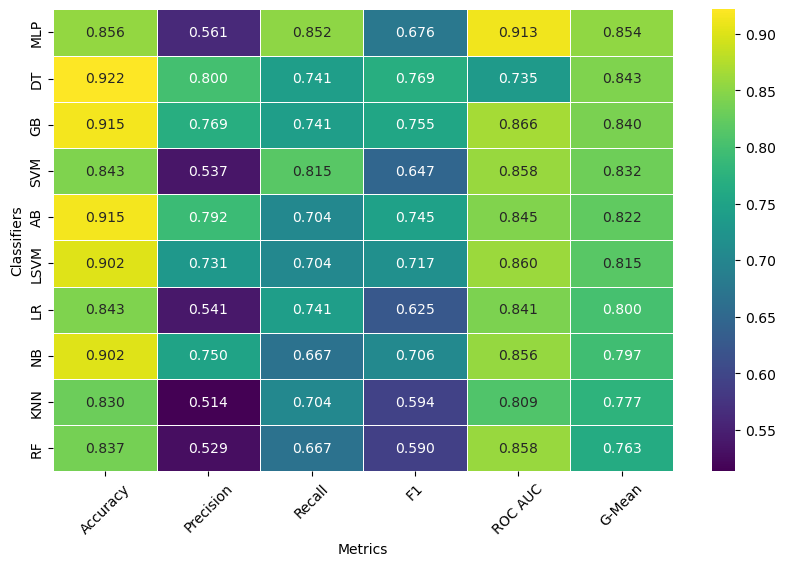

In [ ]:
# Defining the names of the evaluation metrics
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC', 'G-Mean']

# Translation dictionary for metric names
#translation_dict = {
#    'Accuracy': 'Acurácia',
#    'Precision': 'Precisão',
#    'Recall': 'Recall',
#    'F1': 'F1',
#    'ROC AUC': 'ROC AUC',
#    'G-Mean': 'G-Mean'
#}

# Selecting the metrics for the heatmap and configuring the index
heatmap_df = results_df[metric_names].set_index(results_df['classifier'])

# Renaming the columns to Portuguese
#heatmap_df.rename(columns=translation_dict, inplace=True)

# Sorting the DataFrame by G-Mean value
heatmap_df = heatmap_df.sort_values(by='G-Mean', ascending=False)

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_df, cmap='viridis', annot=True, fmt=".3f", linewidths=.5)
#plt.title('Mapa de calor das métricas avaliadas')
plt.xlabel('Metrics')
plt.ylabel('Classifiers')
plt.xticks(rotation=45)
plt.savefig('../results/heatmap.jpeg')
plt.show()


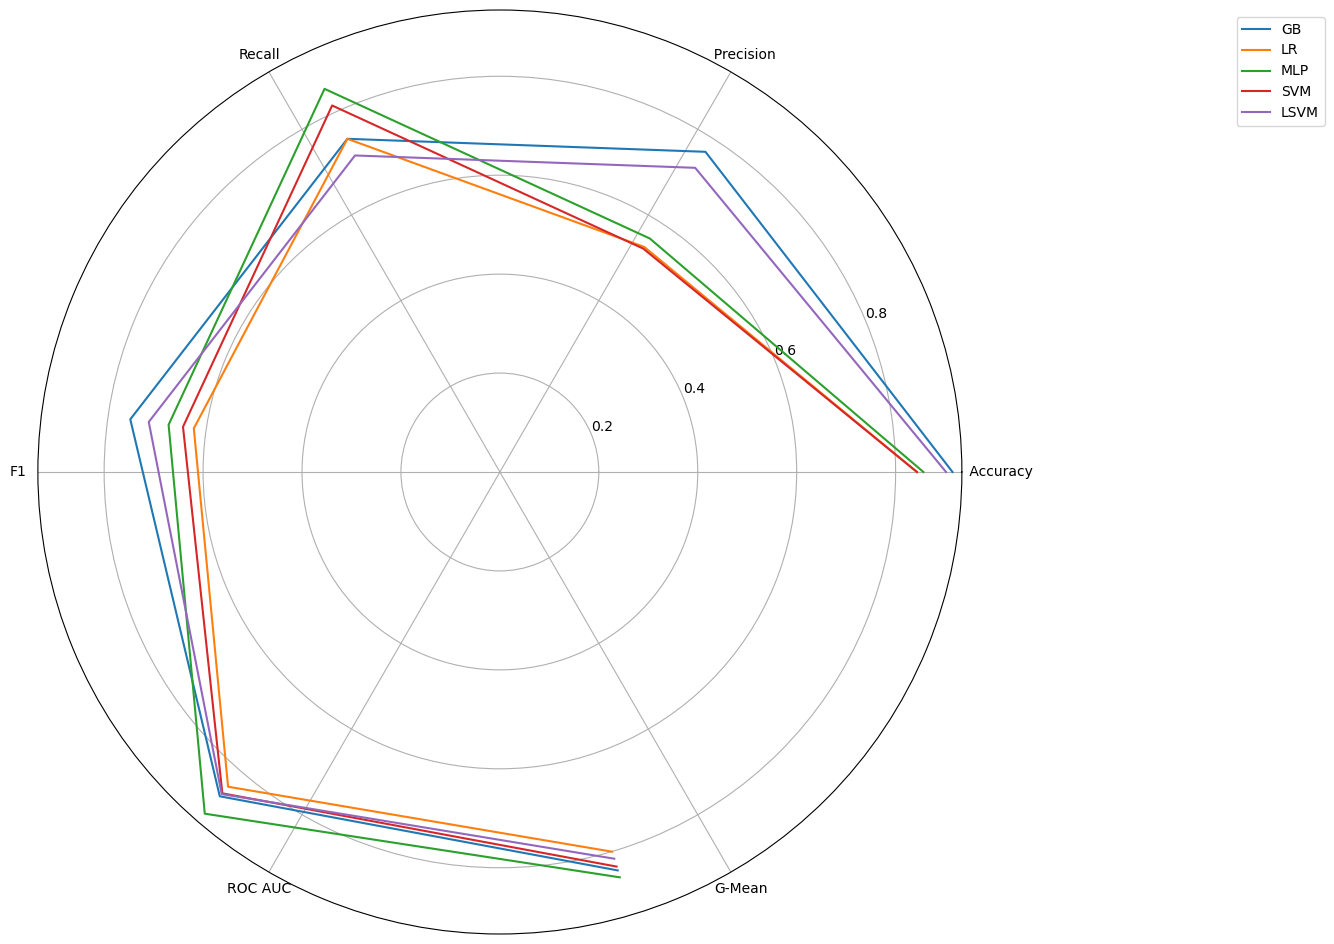

In [12]:
# Polar plot
clean_models = ['GB', 'LR', 'MLP', 'SVM', 'LSVM']
results_df = results_df[results_df['classifier'].isin(clean_models)]

fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': 'polar'})

for i, row in results_df.iterrows():
    ax.plot([row['Accuracy'], row['Precision'], row['Recall'], row['F1'], row['ROC AUC'], row['G-Mean']], label=row['classifier'])

ax.set_xticks(np.linspace(0, 2*np.pi, 6, endpoint=False))
ax.set_xticklabels(['         Accuracy', 
                    '  Precision', 'Recall', 
                    'F1', 'ROC AUC', 'G-Mean'])
ax.set_ylabel('')
ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1))
ax.set_prop_cycle(color=plt.cm.viridis(np.linspace(0, 1, len(results_df))))
plt.show()

Model DT uploaded successfully.


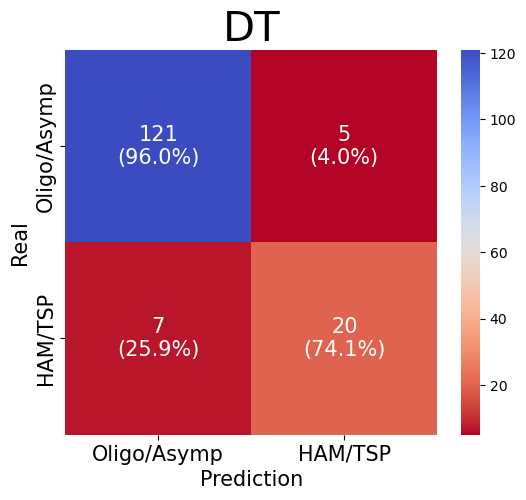

Model GB uploaded successfully.


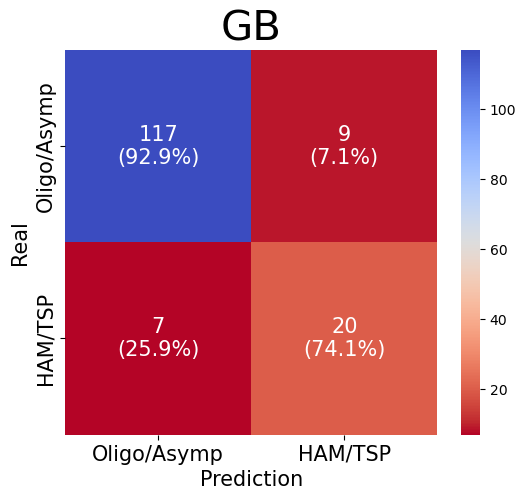

Model LR uploaded successfully.


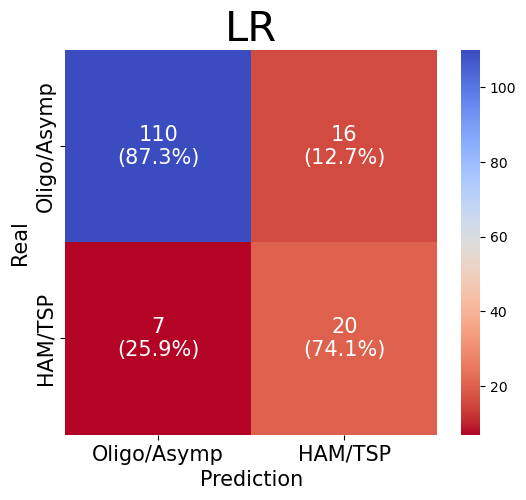

Model MLP uploaded successfully.


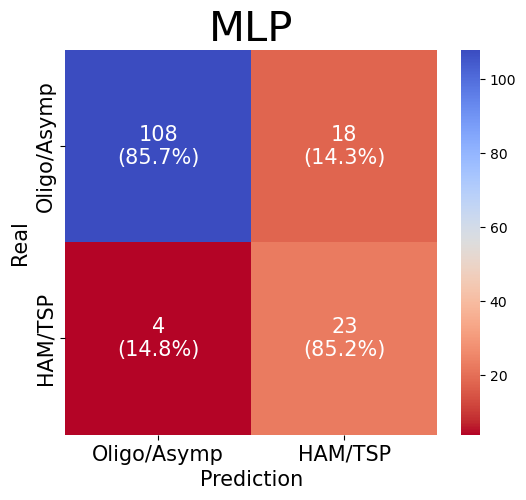

Model NB uploaded successfully.


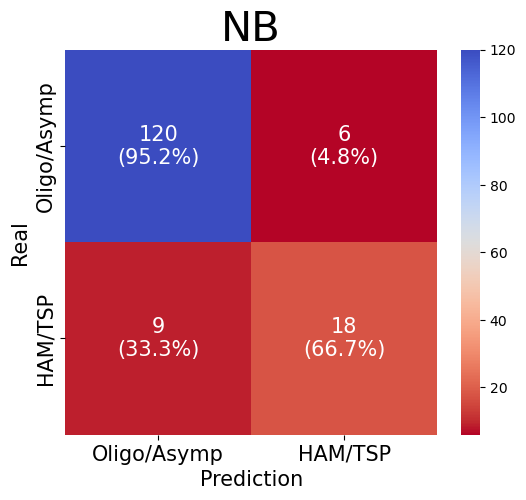

Model RF uploaded successfully.


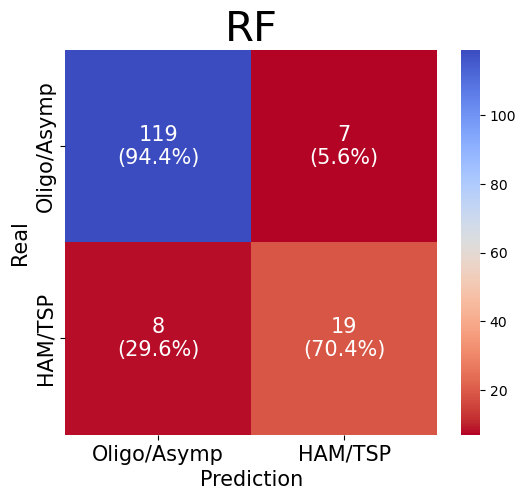

Model SVM uploaded successfully.


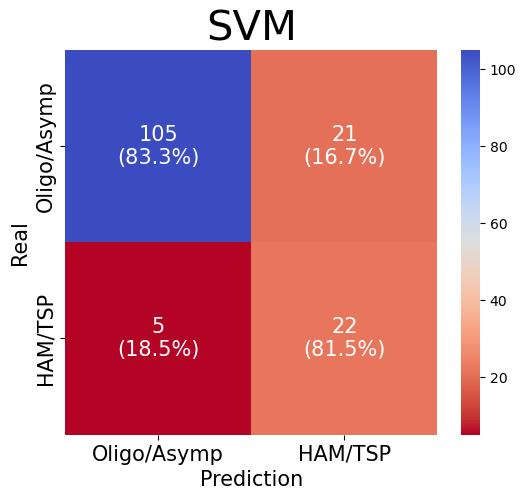

Model KNN uploaded successfully.


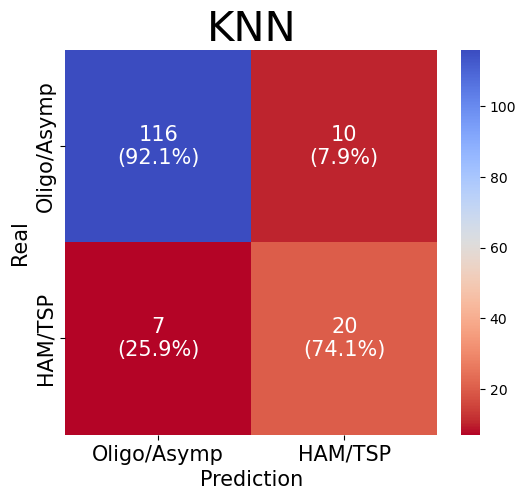

Model AB uploaded successfully.


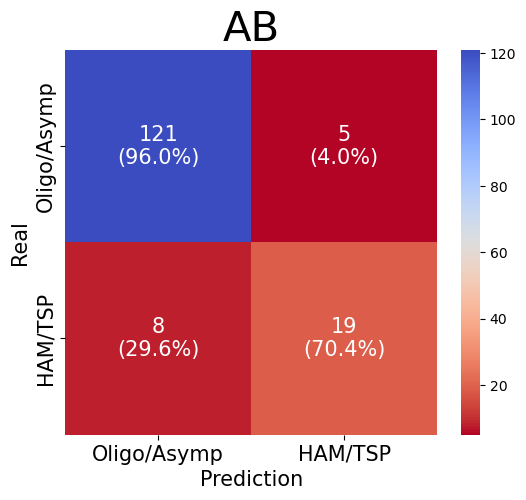

Model LSVM uploaded successfully.


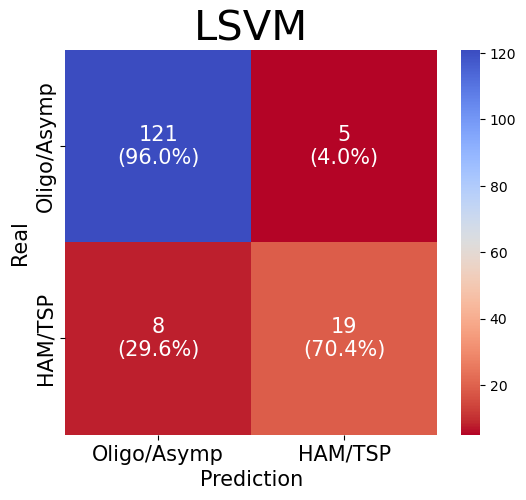

{'DT': Pipeline(steps=[('normalization', MinMaxScaler()),
                ('balancing', RandomUnderSampler(random_state=42)),
                ('classifier',
                 DecisionTreeClassifier(ccp_alpha=0.08373883555532845,
                                        criterion='entropy', max_depth=4,
                                        min_samples_leaf=5, min_samples_split=9,
                                        random_state=42))]), 'GB': Pipeline(steps=[('normalization', MinMaxScaler()),
                ('balancing', RandomUnderSampler(random_state=42)),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=0.010168587136004645,
                                            max_depth=8, min_samples_leaf=6,
                                            min_samples_split=12,
                                            n_estimators=174, random_state=42,
                                            subsample=0.6210749589588561))]), 'LR': Pipeline(steps

In [14]:
def plot_confusion_matrix(model_name, X, y, loo):
    model = classifiers[model_name]
    y_preds = cross_val_predict(model, X, y, cv=loo)
    
    cm = confusion_matrix(y, y_preds)
    cm_percent = np.nan_to_num(cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100)
    
    labels = ['Oligo/Asymp', 'HAM/TSP']
    annot = np.array([[f'{v}\n({p:.1f}%)' for v, p in zip(row, perc)] for row, perc in zip(cm, cm_percent)])
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=annot, fmt='', cmap='coolwarm_r',
                xticklabels=labels, yticklabels=labels,
                annot_kws={"size": 15})
    
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('Prediction', fontsize=15)
    plt.ylabel('Real', fontsize=15)
    plt.title(model_name, fontsize=30)
    
    plt.savefig(f'../results/{model_name}_confusion_matrix.jpeg')
    plt.show()

# Carrega e plota para cada modelo, se existir no dicionário
for model_name in model_names:
    load_model(model_name)
    if model_name in classifiers:
        plot_confusion_matrix(model_name, X, y, loo)

# Verifica os modelos carregados
print(classifiers)


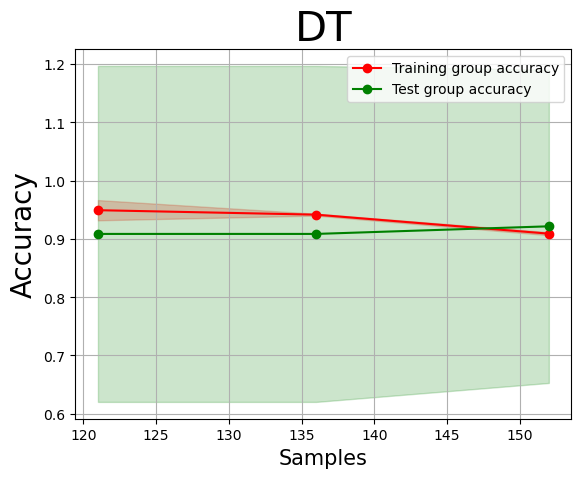

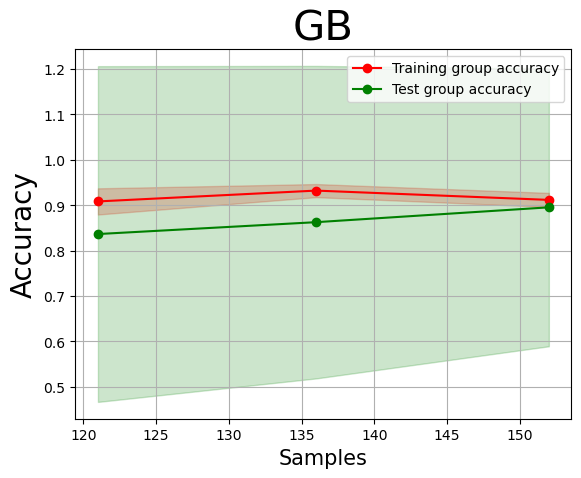

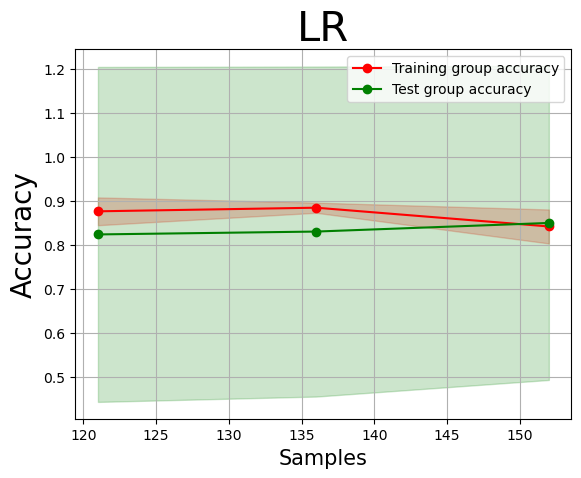

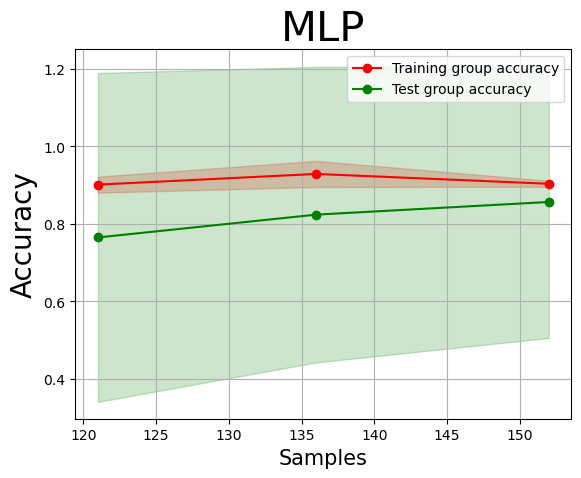

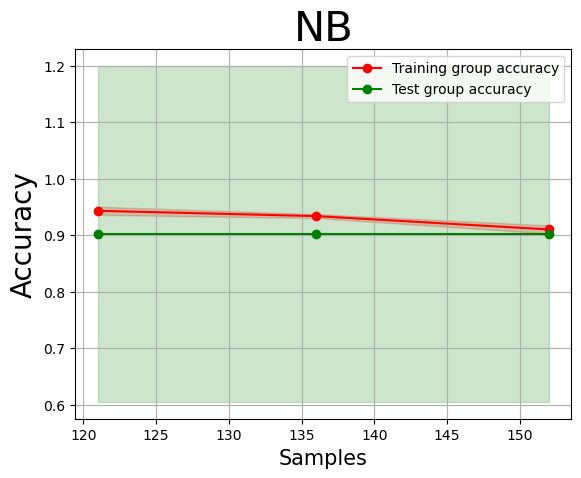

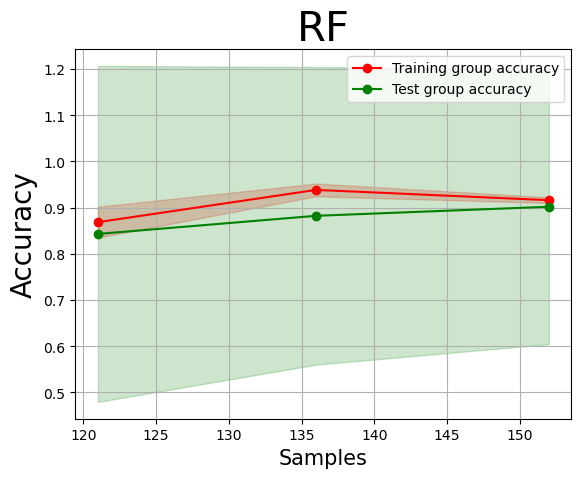

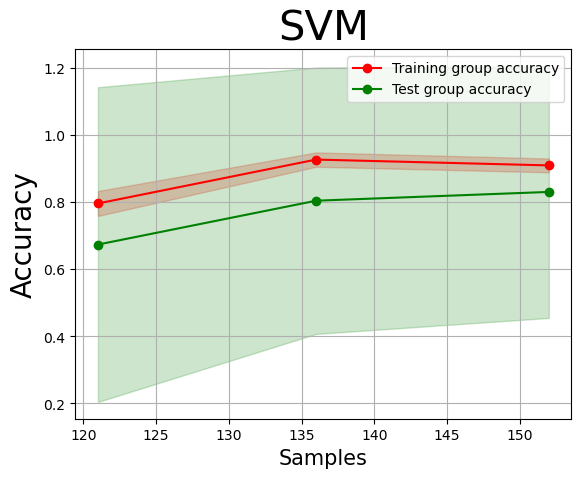

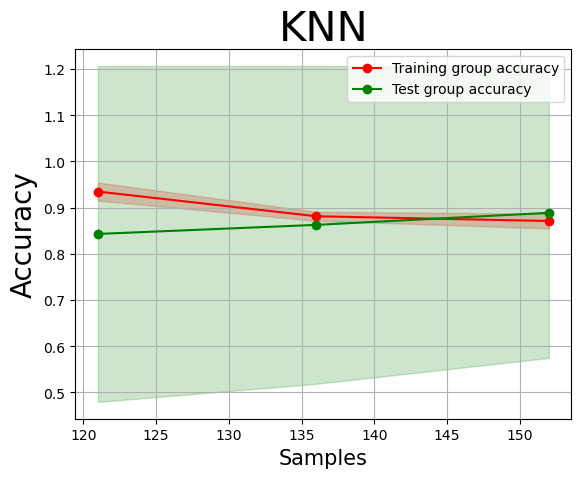

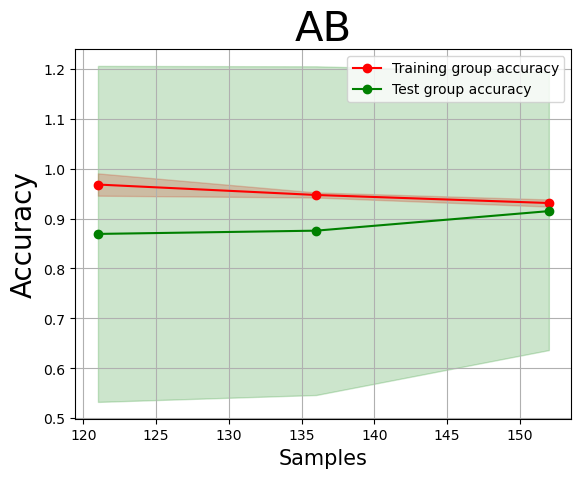

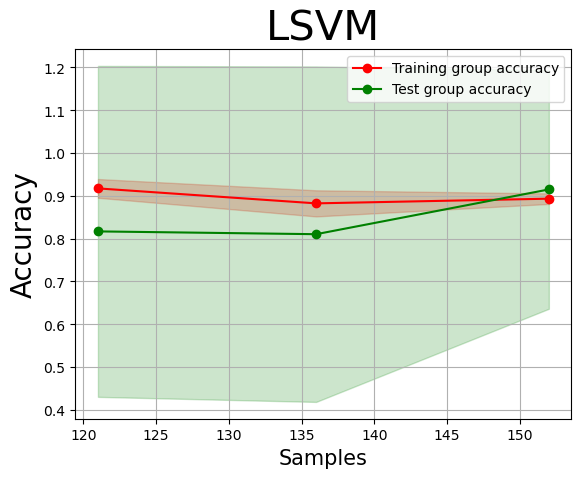

In [18]:
loo = LeaveOneOut()

# Function to plot learning curves with shaded areas for standard deviation
def plot_learning_curve(X, y, classifiers, train_sizes=np.linspace(0.1, 1.0, 10)):
    results_dir = '..\\results\\'  # Adjust the directory path if needed
    for name, estimator in classifiers.items():
        # Get learning curve data
        train_sizes_abs, train_scores, test_scores = learning_curve(
            estimator, X, y, train_sizes=train_sizes, cv=loo, scoring='accuracy', n_jobs=-1
        )

        # Calculate means and standard deviations
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        # Plot the learning curves
        plt.figure()
        plt.title(f'{name}', fontsize = 30)
        plt.xlabel("Samples", fontsize = 15)
        plt.ylabel("Accuracy", fontsize = 20)

        # Plot training data and fill between for standard deviation
        plt.plot(train_sizes_abs, train_scores_mean, 'o-', label="Training group accuracy", color="r")
        plt.fill_between(train_sizes_abs, 
                         train_scores_mean - train_scores_std, 
                         train_scores_mean + train_scores_std, 
                         alpha=0.2, color="r")  # Shadow for training

        # Plot test data and fill between for standard deviation
        plt.plot(train_sizes_abs, test_scores_mean, 'o-', label="Test group accuracy", color="g")
        plt.fill_between(train_sizes_abs, 
                         test_scores_mean - test_scores_std, 
                         test_scores_mean + test_scores_std, 
                         alpha=0.2, color="g")  # Shadow for cross-validation

        # Show legend and grid
        plt.legend(loc="best")
        plt.grid(True)

        # Save the plot
        plot_filename = os.path.join(results_dir, f'curva_aprendizado_{name}.png')
        plt.savefig(plot_filename)
        plt.show()

# Example usage: Call the plot_learning_curve function with your data
plot_learning_curve(X, y, classifiers)